<a href="https://colab.research.google.com/github/talalqaiser/CIFAR-10-using-VGG16/blob/main/CIFAR_10_using_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets.fashion_mnist import load_data
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import to_categorical
import cv2
from sklearn.metrics import confusion_matrix
from keras.datasets.cifar10 import load_data

data loaded
(50000, 32, 32, 3)
original dim: (50000, 32, 32, 3)


new dim: (50000, 75, 75, 3)


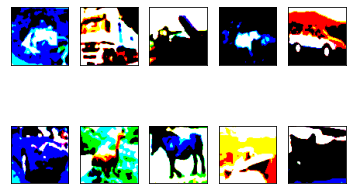

In [2]:

(xtrain, ytrain),(xtest, ytest)=load_data()
print('data loaded')

print(xtrain.shape)

def img_resize(x):
  res_x = []
  for img in x:
    res_img = cv2.resize(img, dsize=(75, 75), interpolation=cv2.INTER_CUBIC)
    res_x.append(res_img)
  res_x = np.array(res_x)
  res_x = preprocess_input(res_x)
  return res_x

print('original dim:', xtrain.shape)

xtrain = img_resize(xtrain)
xtest = img_resize(xtest)

print('new dim:', xtrain.shape)


# create a grid of 2x5 images for 10 classes
for i in range(0, 10):
  ax = plt.subplot(2,5,1 + i)
  plt.imshow(xtrain[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

# show the plot
plt.show()

# xtrain = preprocess_input(xtrain)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

In [3]:
# downloaded VGG16  without the classifier part
model = VGG16(weights = 'imagenet', include_top=False, input_shape=(75, 75, 3))   # min (224, 224, 3)
model.summary()

# freeze the feature extraction layers that have been trained on the ImageNet dataset
for layer in model.layers:
  layer.trainable = False

model.summary()

# save the output of the last layer of VGG16 to be the input to the next layer
last_layer = model.get_layer('block5_pool')
last_output = last_layer.output 

x = Flatten()(last_output)
x = Dense(100, activation='relu')(x)
x = Dense(10, activation='softmax', name='softmax')(x)

# Define a new_model that takes the input of the base model as its input and the output of the last softmax layer as an output 
new_model = Model(inputs=model.input, outputs=x) 

new_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 75, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 75, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 37, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 37, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 37, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [4]:
new_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
hist = new_model.fit(xtrain, ytrain, batch_size=32, epochs=5, validation_data=(xtest, ytest), verbose=2, shuffle=True)

Epoch 1/5
1563/1563 - 3564s - loss: 0.8736 - accuracy: 0.7316 - val_loss: 0.6400 - val_accuracy: 0.7840 - 3564s/epoch - 2s/step
Epoch 2/5
1563/1563 - 3568s - loss: 0.5301 - accuracy: 0.8194 - val_loss: 0.6277 - val_accuracy: 0.7933 - 3568s/epoch - 2s/step
Epoch 3/5
1563/1563 - 3559s - loss: 0.4377 - accuracy: 0.8490 - val_loss: 0.6509 - val_accuracy: 0.7913 - 3559s/epoch - 2s/step
Epoch 4/5
1563/1563 - 3555s - loss: 0.3795 - accuracy: 0.8682 - val_loss: 0.6397 - val_accuracy: 0.7997 - 3555s/epoch - 2s/step
Epoch 5/5
1563/1563 - 3562s - loss: 0.3255 - accuracy: 0.8860 - val_loss: 0.6331 - val_accuracy: 0.8066 - 3562s/epoch - 2s/step


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
0.5092699527740479
Training and validation loss    :  0.5092699527740479 0.6382805585861206
Training and validation accuracy:  0.8308239936828613 0.794979989528656
313/313 [==============================] - 595s 2s/step - loss: 0.6331 - accuracy: 0.8066
accuracy : [0.6331474184989929, 0.8065999746322632]


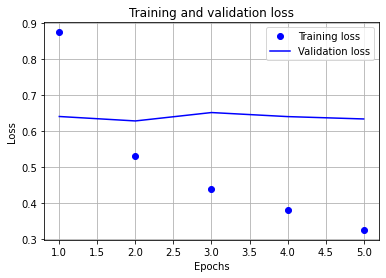

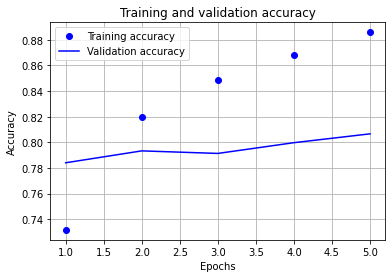

In [6]:
print(hist.history.keys())
loss = hist.history['loss']
print(np.mean(loss))
accuracy = hist.history['accuracy']
val_loss = hist.history['val_loss']
val_accuracy = hist.history['val_accuracy']

print('Training and validation loss    : ', np.mean(loss), np.mean(val_loss))
print('Training and validation accuracy: ', np.mean(accuracy), np.mean(val_accuracy))

ypred = new_model.predict(xtest)
score = new_model.evaluate(xtest, ytest)
print('accuracy :', score)

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
